In [ ]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
# ##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

conda install conda-forge::r-fmesher
conda install conda-forge::r-exactextractr
conda install conda-forge::r-sn
conda install conda-forge::r-inlabru
conda install conda-forge::r-fields

In [1]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
# library(exactextractr)

library(ggplot2)
library(viridis)
# library(sn)

Warning message:
“package ‘INLA’ was built under R version 4.4.1”
Loading required package: sp

This is INLA_24.06.27 built 2024-06-27 02:36:04 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required

In [2]:
# ghana <- st_read('/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GHA/GHA_aoi.shp') %>% st_transform(crs=6933)
ghana <- st_read('/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Extent_1.gpkg') %>% st_transform(crs=6933)

Reading layer `output' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Extent_1.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 7 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -2.511797 ymin: 6.911778 xmax: -2.261797 ymax: 7.161778
Geodetic CRS:  WGS 84


In [3]:
GEDI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Extent_1_L4A.gpkg") %>% st_transform(crs=6933)
# LANG <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/NLang_height_Tile.tif") %>% project("epsg:6933")
CCI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Hansen_1.tif") %>% project("epsg:6933")

Reading layer `gha_l4a_predict_af_coarse_fit_af_sqrt_sqrt_snowdon_1' from data source `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Extent_1_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 7764 features and 21 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -2.511785 ymin: 6.911779 xmax: -2.261847 ymax: 7.161753
Geodetic CRS:  WGS 84


In [7]:
writeRaster(CCI, filename="/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/Hansen_1_6933_C.tif", overwrite=TRUE, gdal=c("COMPRESS=LZW"))

In [4]:
# GEDI.plot = exactextractr::exact_extract(LANG, st_buffer(GEDI,25), 'mean')
# GEDI$LANG <- GEDI.plot
# plot((GEDI$AGBD_1),GEDI$LANG)


Call:
lm(formula = sqrt(GEDI$AGBD_1) ~ GEDI$CCI)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3403 -0.5532 -0.0141  0.5703  4.4680 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.5209455  0.0318340   16.36   <2e-16 ***
GEDI$CCI    0.0415608  0.0006123   67.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7657 on 7762 degrees of freedom
Multiple R-squared:  0.3724,	Adjusted R-squared:  0.3724 
F-statistic:  4607 on 1 and 7762 DF,  p-value: < 2.2e-16


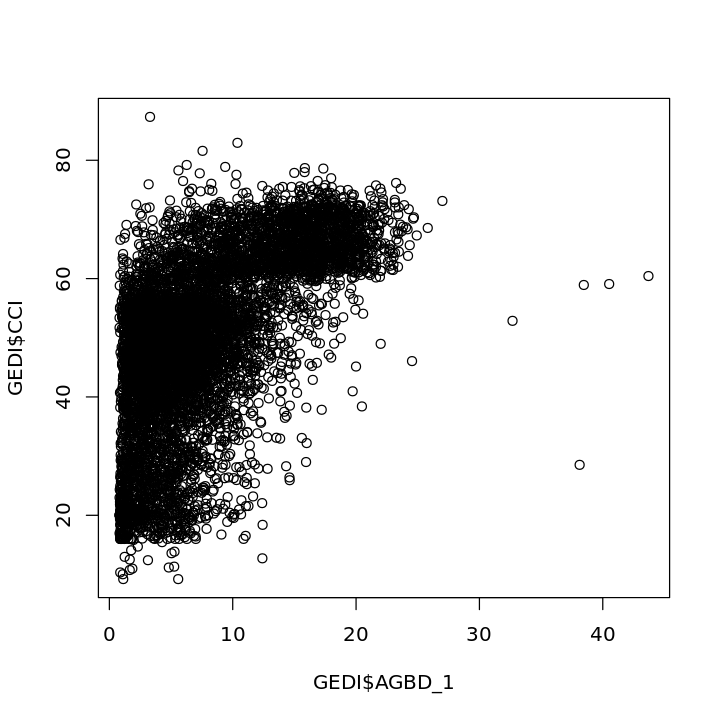

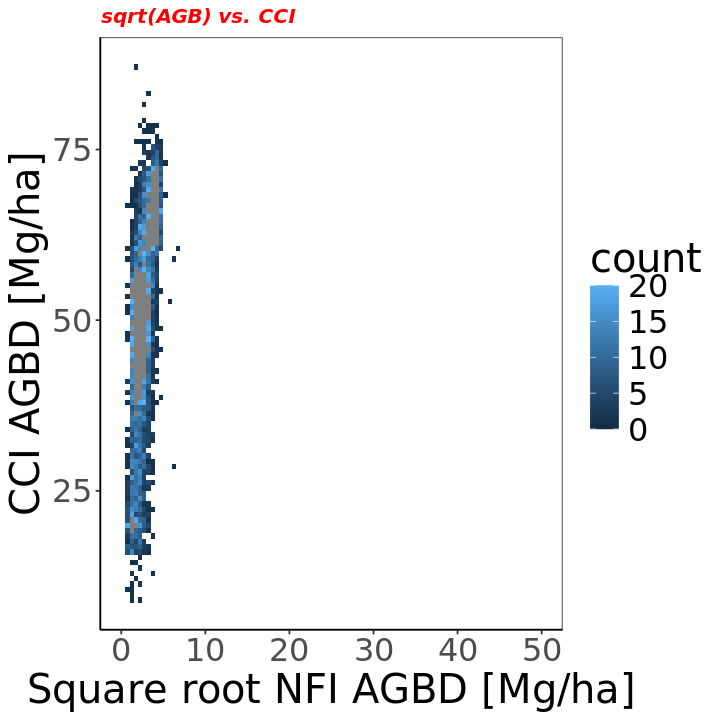

In [17]:
# CCI.plot = exactextractr::exact_extract(CCI, st_buffer(GEDI,25), 'mean')
GEDI$CCI <- CCI.plot
plot(GEDI$AGBD_1,GEDI$CCI)
summary(lm(sqrt(GEDI$AGBD_1) ~ GEDI$CCI))
GEDI$AGBD_1 = sqrt(GEDI$AGBD_1)
ggplot(data=GEDI, aes(x=AGBD_1, y=CCI) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 20)) + xlab("Square root NFI AGBD [Mg/ha]") + ylab("CCI AGBD [Mg/ha]") + ggtitle("sqrt(AGB) vs. CCI") + xlim(0,50) + 
  theme_bw() + theme(text = element_text(size = 24),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

In [8]:
coords <- as.data.frame(st_coordinates(GEDI))
GEDI$X <- coords$X
GEDI$Y <- coords$Y
write.csv(GEDI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/GEDIL4A_and_COVARIATES.csv",row.names=FALSE) #Save the data

In [10]:
DATA = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/GEDIL4A_and_COVARIATES.csv")
DATA$gedi.agbd <- (DATA$AGBD_1)
DATA$cci.height <- (DATA$CCI)

dt = sort(sample(nrow(DATA), nrow(DATA)*.5))
DATA <- DATA[dt,]
write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA.csv",row.names=FALSE) #Save the data
DATA_TEST <- DATA[-dt,]
write.csv(DATA_TEST,"/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA_TEST.csv",row.names=FALSE) #Save the data

[1] 3882 5126

[1] 3882

[1] 3882

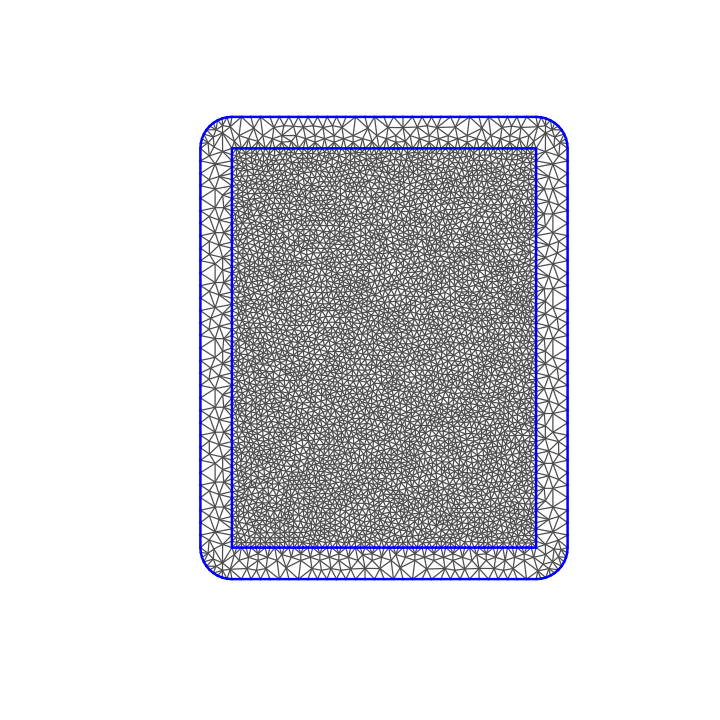

In [31]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA.csv")
DATA$gedi.agbd <- (DATA$gedi.agbd)^(1/3)

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
gedi.agbd <- DATA$gedi.agbd
cci.height <- DATA$cci.height

max.edge = 500
ghana.buffer = st_buffer(ghana, dist = max.edge*5) # We also make a 5 km buffer around ghana to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(ghana, "Spatial"), as(ghana.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5
plot(mesh)
dim(A.plot)
length(gedi.agbd)
length(cci.height)

Time used:
    Pre = 0.786, Running = 18.6, Post = 0.558, Total = 20 
Fixed effects:
           mean     sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 1.118 12.208    -22.809    1.118     25.045 1.118   0
cci       0.038  2.125     -4.127    0.038      4.202 0.038   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 7.00e-01 1.70e-02   6.67e-01 7.00e-01
Range for alpha.spat                    1.75e+05 1.58e+05   3.29e+04 1.29e+05
Stdev for alpha.spat                    4.31e+00 3.88e+00   8.01e-01 3.20e+00
Range for beta.spat                     2.63e+05 6.24e+05   1.15e+03 7.95e+04
Stdev for beta.spat                     4.78e-01 1.14e+00   2.00e-03 1.43e-01
                                        0.975quant     mode
Precision for the Gaussian observations   7.34e-01 7.00e-01
Range for alpha.spat       

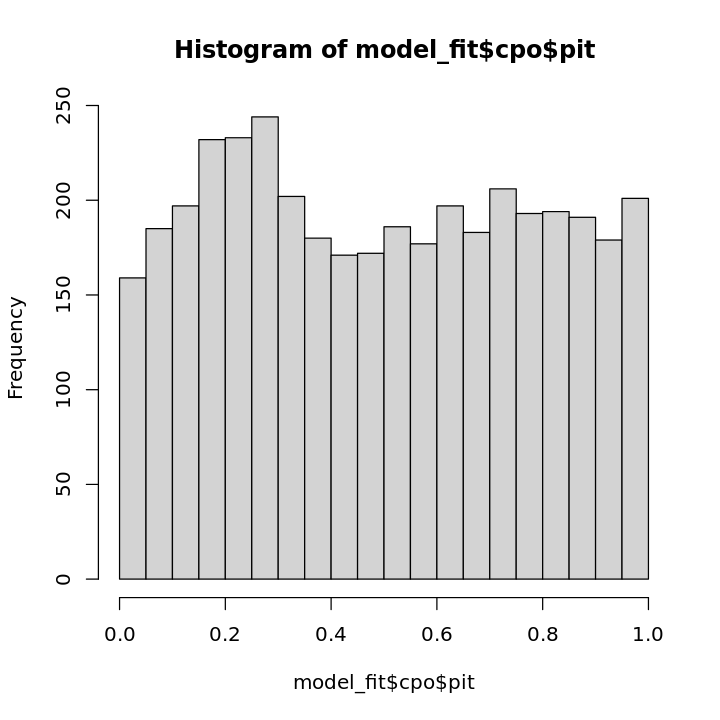

In [32]:
### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  cci +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            1, 
                            A.plot, 
                            Diagonal(x = cci.height)%*%A.plot),# 
                   effects = list(
                     intercept = rep(1, n.plot),
                     cci = cci.height,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)
summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Ghana/INLA_model_fit.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

  |======================================================================| 100%


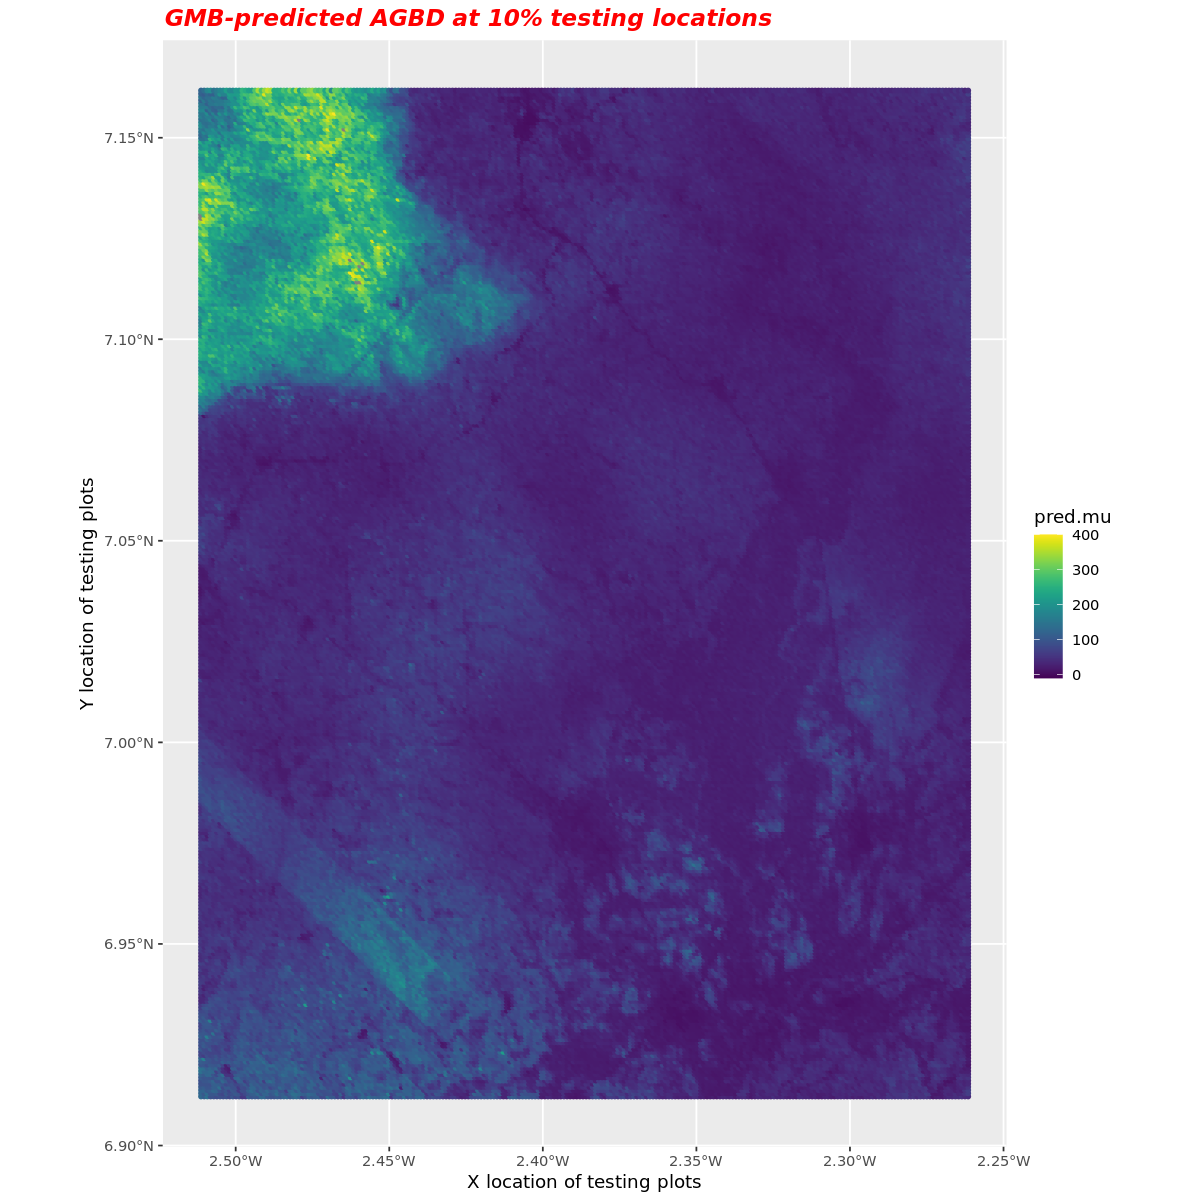

In [25]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(ghana, cellsize = c(100,100), what = "centers") %>% st_as_sf()
cci.pred = exactextractr::exact_extract(CCI, st_buffer(grid_to_predict,25), 'mean')
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(-10, 400)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

Time used:
    Pre = 1.25, Running = 297, Post = 16, Total = 314 
Fixed effects:
           mean     sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 1.104 13.783     -25.91    1.104     28.117 1.104   0
cci       0.037  2.458      -4.78    0.037      4.854 0.037   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 7.00e-01 1.70e-02   6.67e-01 7.00e-01
Range for alpha.spat                    1.67e+05 1.36e+05   3.64e+04 1.29e+05
Stdev for alpha.spat                    4.09e+00 3.35e+00   8.49e-01 3.15e+00
Range for beta.spat                     3.91e+05 9.34e+05   5.79e+03 1.41e+05
Stdev for beta.spat                     6.80e-01 1.62e+00   1.00e-02 2.47e-01
                                        0.975quant     mode
Precision for the Gaussian observations   7.34e-01 7.01e-01
Range for alpha.spat           

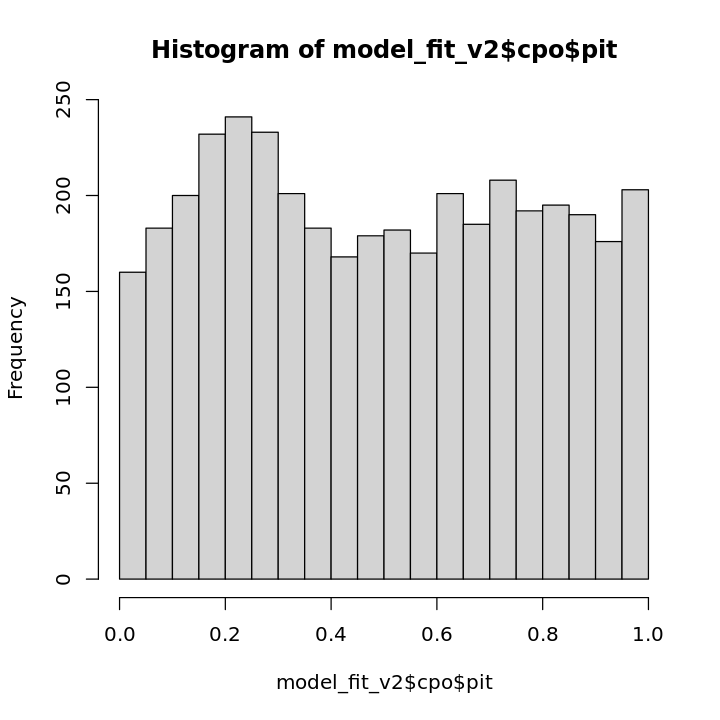

In [33]:
################## IMPROVING OUR MODEL ############

# Before we move ahead, let's try improve our model by making a finer mesh. We choose to rougly 2/3rds our max.edge (10 km) and see if our model improves. 

max.edge = 100
ghana.buffer = st_buffer(ghana, dist = max.edge*5) # We also make a 5 km buffer around ghana to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(ghana, "Spatial"), as(ghana.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  cci +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            1, 
                            A.plot, 
                            Diagonal(x = cci.height)%*%A.plot),# 
                   effects = list(
                     intercept = rep(1, n.plot),
                     cci = cci.height,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 control.mode = list(theta = model_fit$mode$theta, restart = T), #Ask INLA to restart the model using the previous iteration
                 verbose = TRUE)
summary(model_fit_v2)
save(model_fit_v2, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_v2.RData")
hist(model_fit_v2$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/my-public-bucket/Data/NASA_CMS_2023/ghana/RData_saves/INLA_model_fit_v2.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

# We don't see a massive improvement in either the PIT distributions, the DIC or WAIC values. 
# We can conclude that using a max.edge of 10 km is sufficient and there is no further need to refine our mesh. 

  |======================================================================| 100%


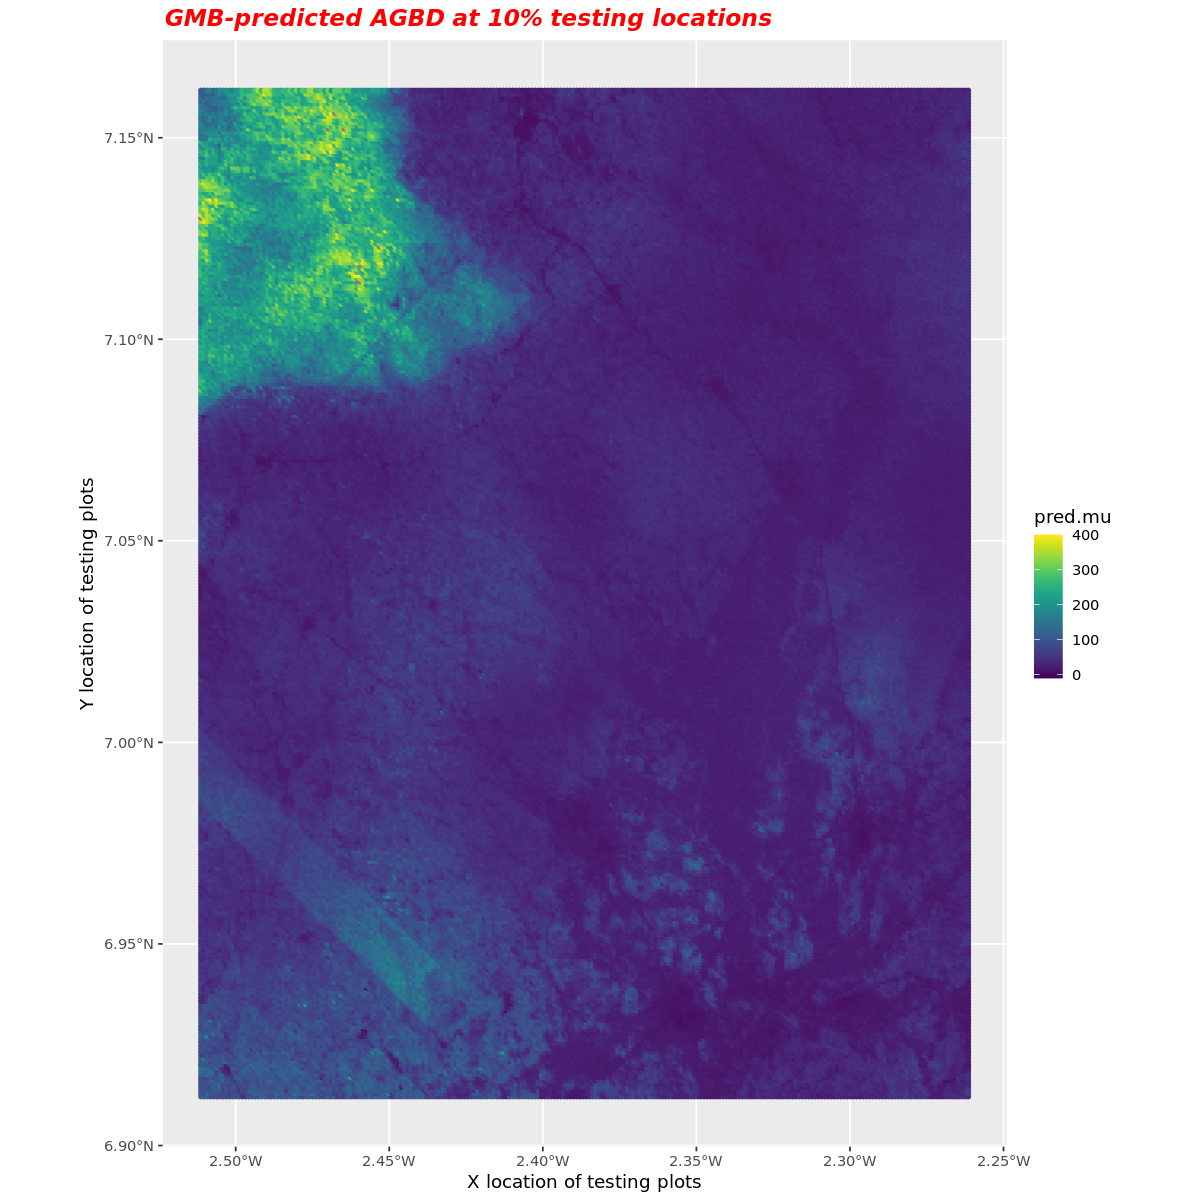

In [36]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_v2.RData")
grid_to_predict = st_make_grid(ghana, cellsize = c(100,100), what = "centers") %>% st_as_sf()
cci.pred = exactextractr::exact_extract(CCI, st_buffer(grid_to_predict,25), 'mean')
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(-10, 400)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

Warning message:
“Removed 181 rows containing missing values or values outside the scale range
(`geom_point()`).”


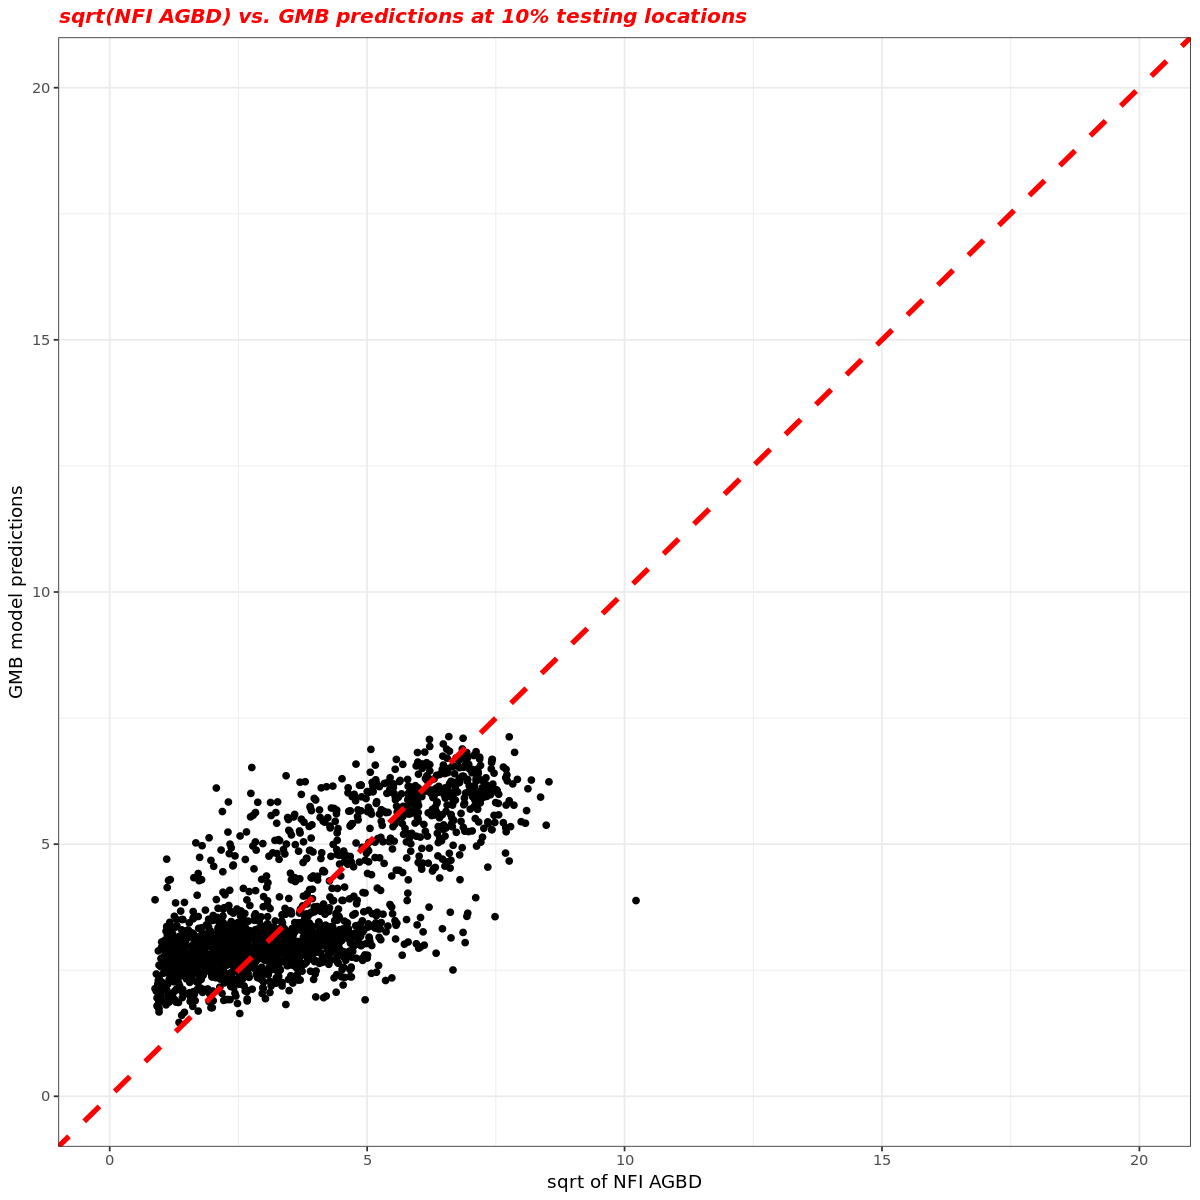

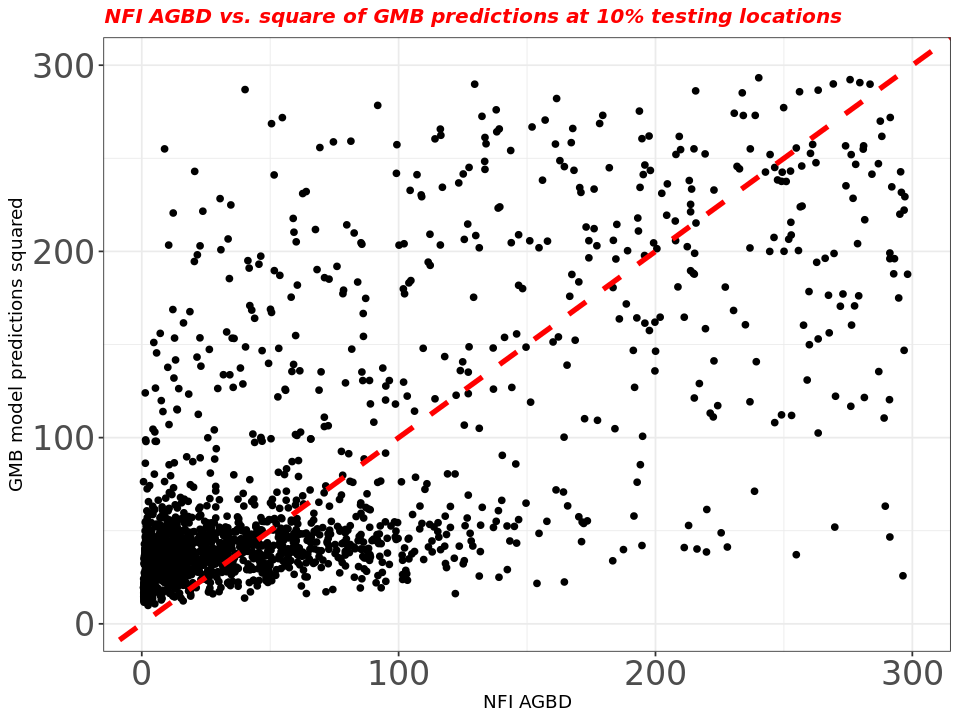

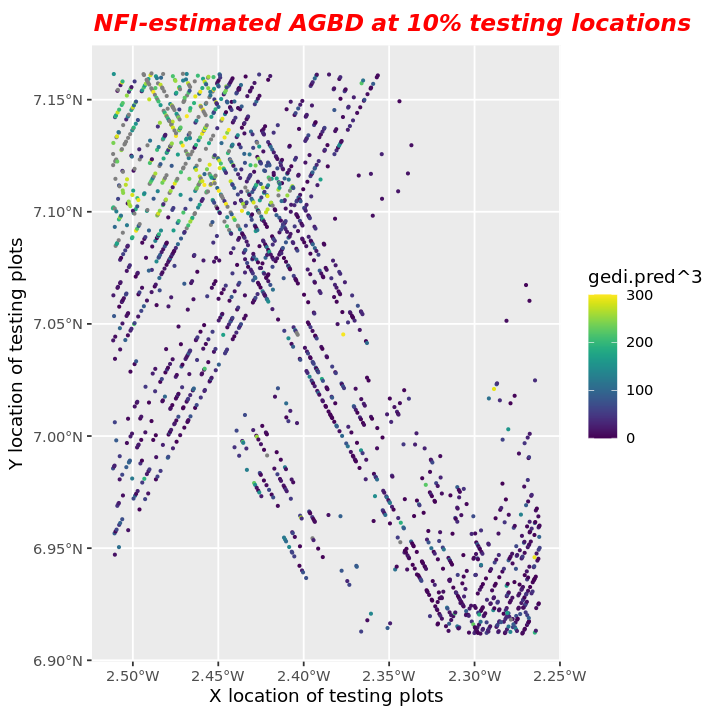

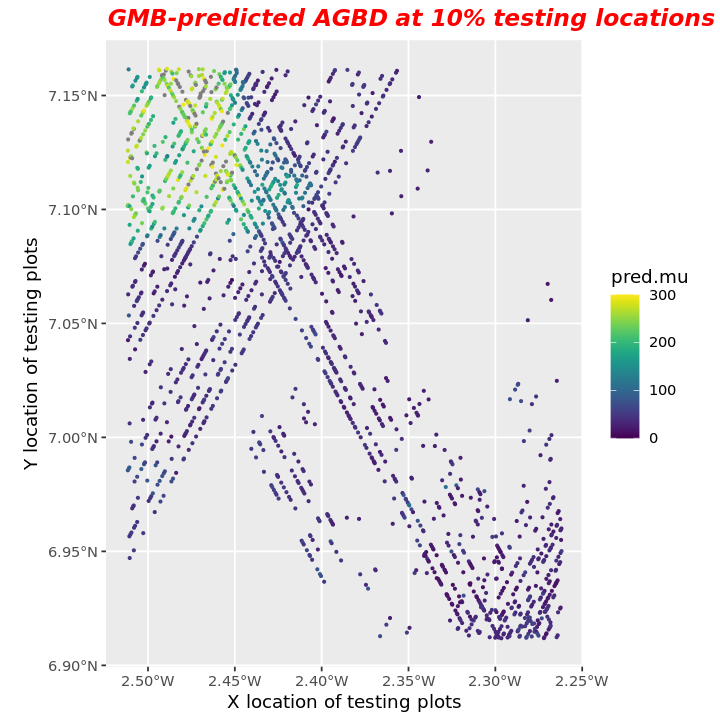

In [26]:
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA_TEST.csv")
DATA_TEST$gedi.agbd <- (DATA_TEST$gedi.agbd)^(1/3)

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)
cci.pred <- DATA_TEST$cci.height

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

################## COMPUTE A HEURISTIC FOR ACCURACY, LIKE AN R2 VALUE #############
 # Computing a value like an R^2 for our testing locations will give us an idea of prediction error at unobserved locations

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred^3, PRED.SD=pred.sd, RES=gedi.pred^3-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred^3),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

[1]   3882 115291

[1] 3882

Time used:
    Pre = 0.817, Running = 238, Post = 8.15, Total = 247 
Fixed effects:
            mean     sd 0.025quant 0.5quant 0.975quant   mode kld
intercept 38.599 19.816      -0.24   38.599     77.437 38.599   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model

Model hyperparameters:
                                           mean      sd 0.025quant 0.5quant
Precision for the Gaussian observations    0.00    0.00       0.00     0.00
Range for alpha.spat                    7793.02 1528.10    5311.00  7617.36
Stdev for alpha.spat                      75.82   10.66      57.57    74.89
                                        0.975quant    mode
Precision for the Gaussian observations       0.00    0.00
Range for alpha.spat                      11301.41 7230.75
Stdev for alpha.spat                         99.46   72.73

Deviance Information Criterion (DIC) ...............: 44599.98
Deviance Information Criterion (DIC, saturated) ....: 1700.91
Effective number of parameters ....

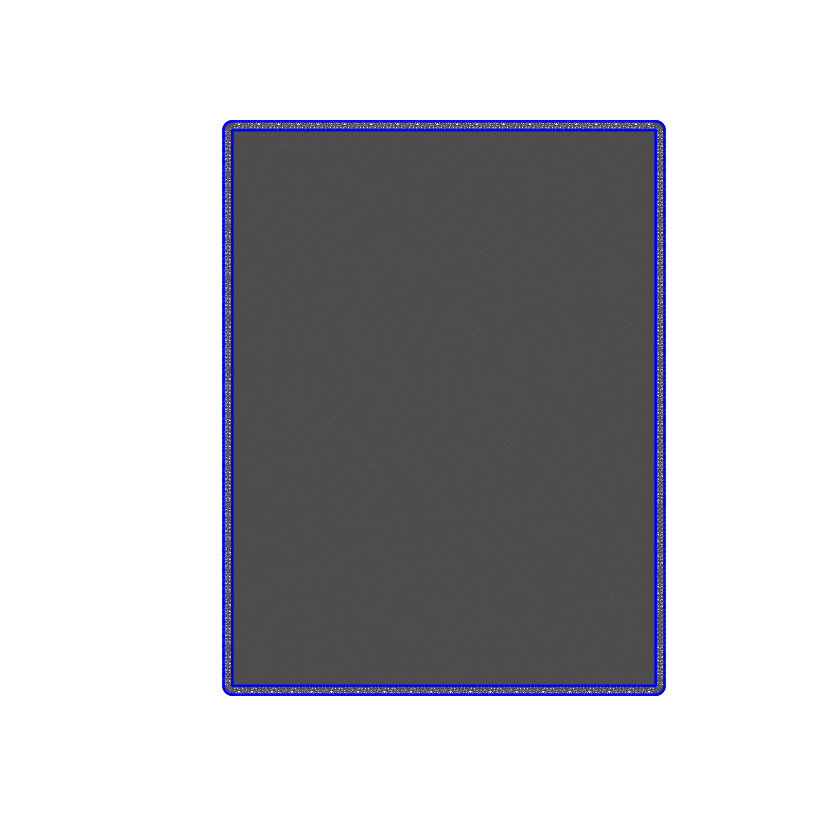

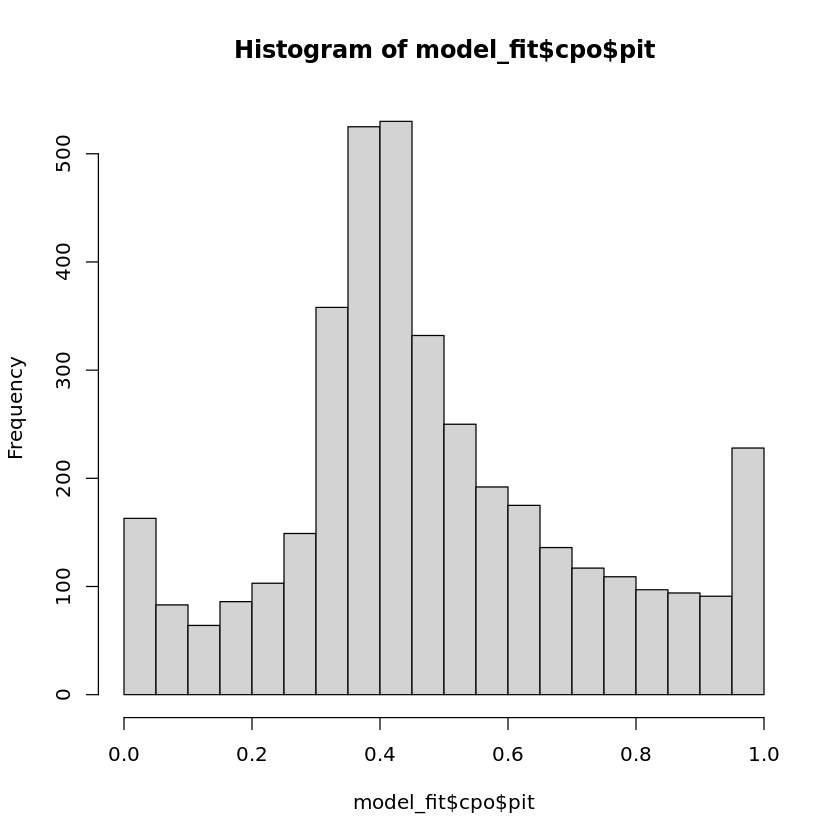

In [8]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA.csv")
DATA$gedi.agbd <- (DATA$gedi.agbd)

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
gedi.agbd <- (DATA$gedi.agbd)

max.edge = 100
ghana.buffer = st_buffer(ghana, dist = max.edge*5) # We also make a 5 km buffer around ghana to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(ghana, "Spatial"), as(ghana.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5
plot(mesh)
dim(A.plot)
length(gedi.agbd)

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  f(alpha.spat, model = spde.alpha)
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     alpha.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)
summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_DIRECT.RData")
hist(model_fit$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Ghana/INLA_model_fit.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 406 rows containing missing values or values outside the scale range
(`geom_point()`).”


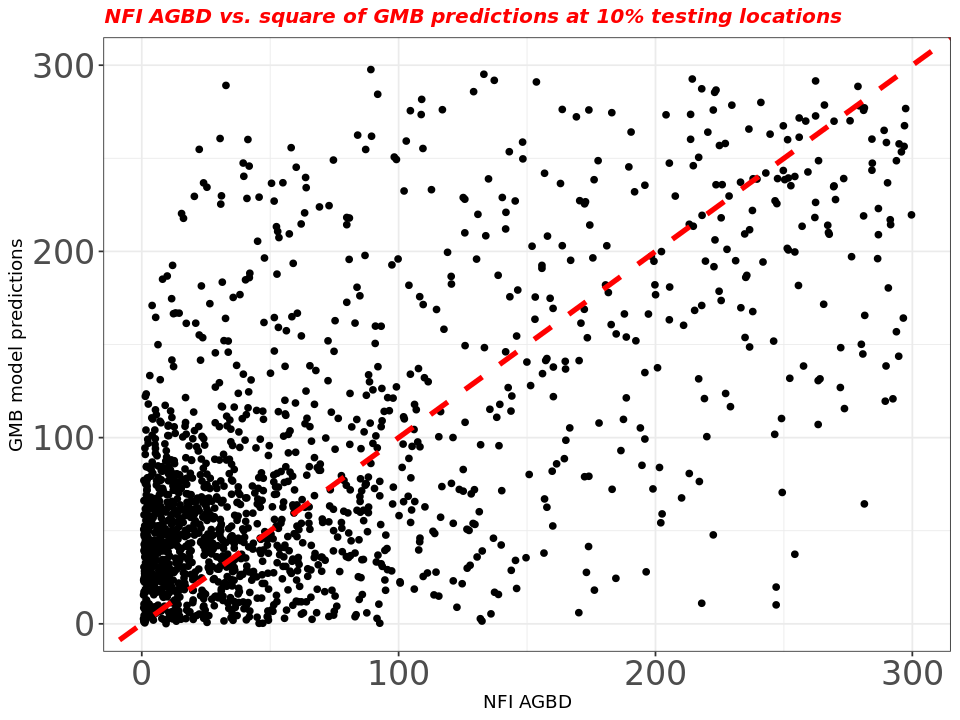

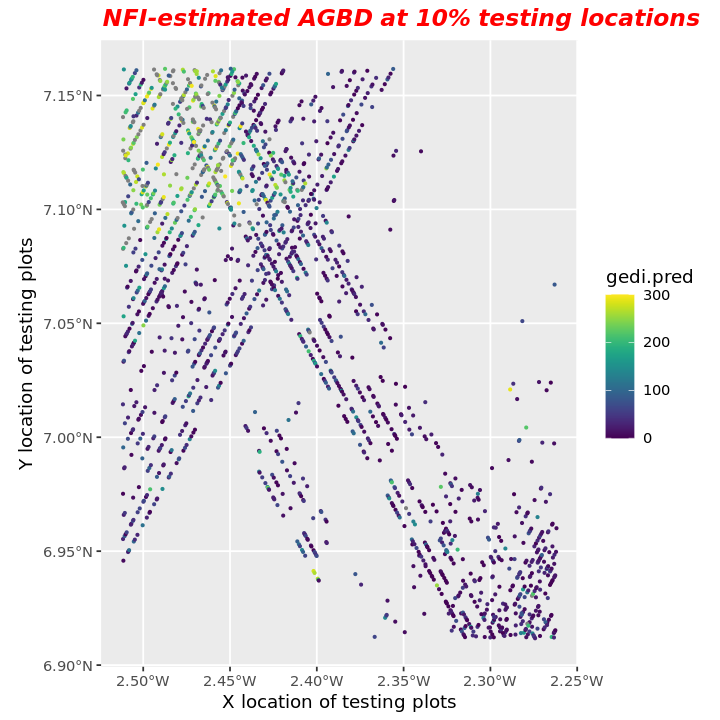

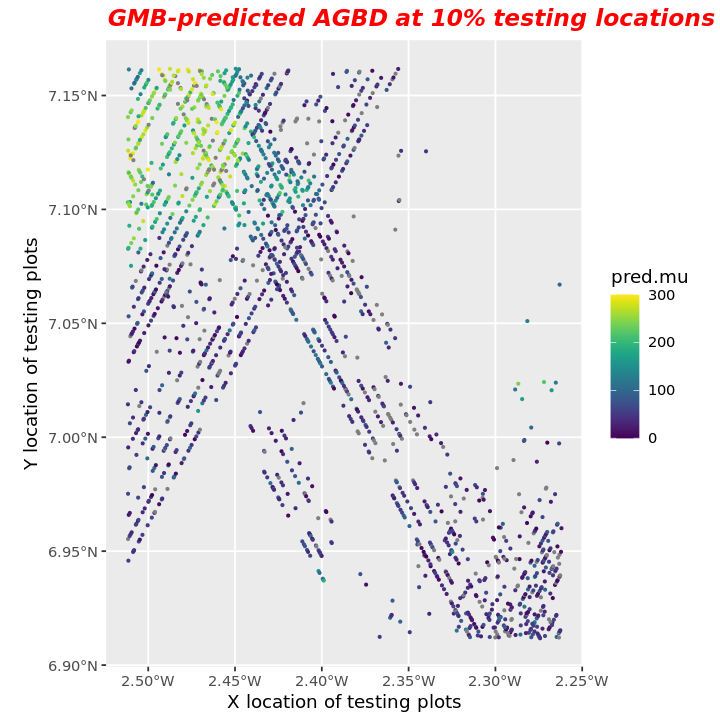

In [9]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_DIRECT.RData")
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA_TEST.csv")

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)

samples = inla.posterior.sample(n = 5, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

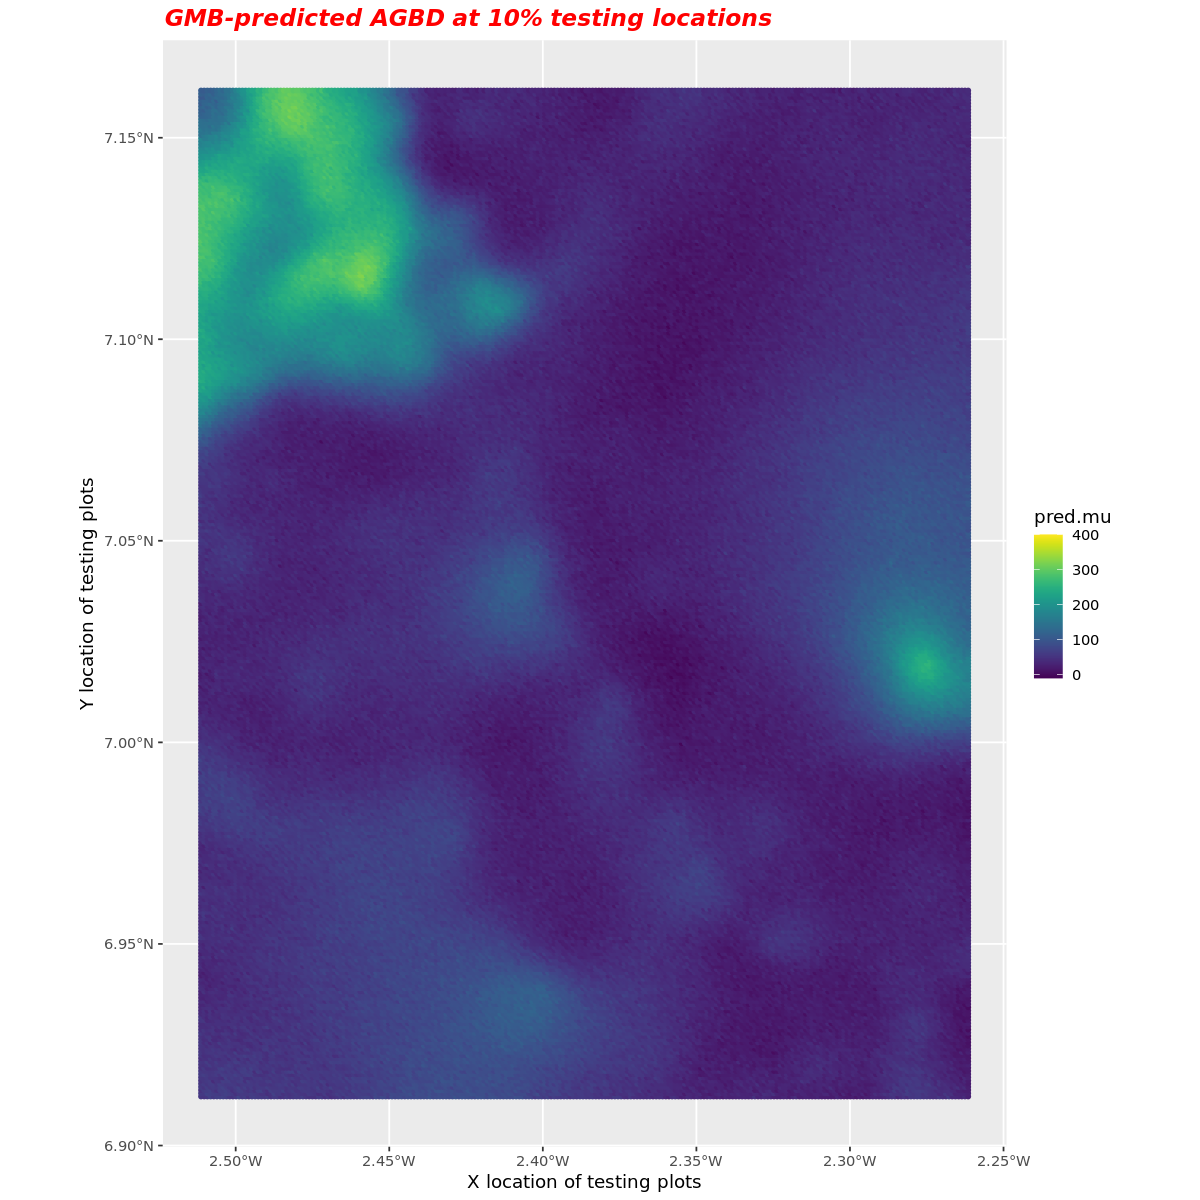

In [33]:
grid_to_predict = st_make_grid(ghana, cellsize = c(100,100), what = "centers") %>% st_as_sf()
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(-10, 400)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

In [15]:
class(grid)

[1] "matrix" "array"

In [43]:
################## IMPROVING OUR MODEL ############

# Before we move ahead, let's try improve our model by making a finer mesh. We choose to rougly 2/3rds our max.edge (10 km) and see if our model improves. 

max.edge = 50
ghana.buffer = st_buffer(ghana, dist = max.edge*5) # We also make a 5 km buffer around ghana to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(ghana, "Spatial"), as(ghana.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  f(alpha.spat, model = spde.alpha)
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     alpha.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 control.mode = list(theta = model_fit$mode$theta, restart = T), #Ask INLA to restart the model using the previous iteration
                 verbose = TRUE)
summary(model_fit_v2)
save(model_fit_v2, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/INLA_model_DIRECT_v2.RData")
hist(model_fit_v2$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/my-public-bucket/Data/NASA_CMS_2023/ghana/RData_saves/INLA_model_fit_v2.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

# We don't see a massive improvement in either the PIT distributions, the DIC or WAIC values. 
# We can conclude that using a max.edge of 10 km is sufficient and there is no further need to refine our mesh. 

Warning message:
“Removed 104 rows containing missing values or values outside the scale range
(`geom_point()`).”


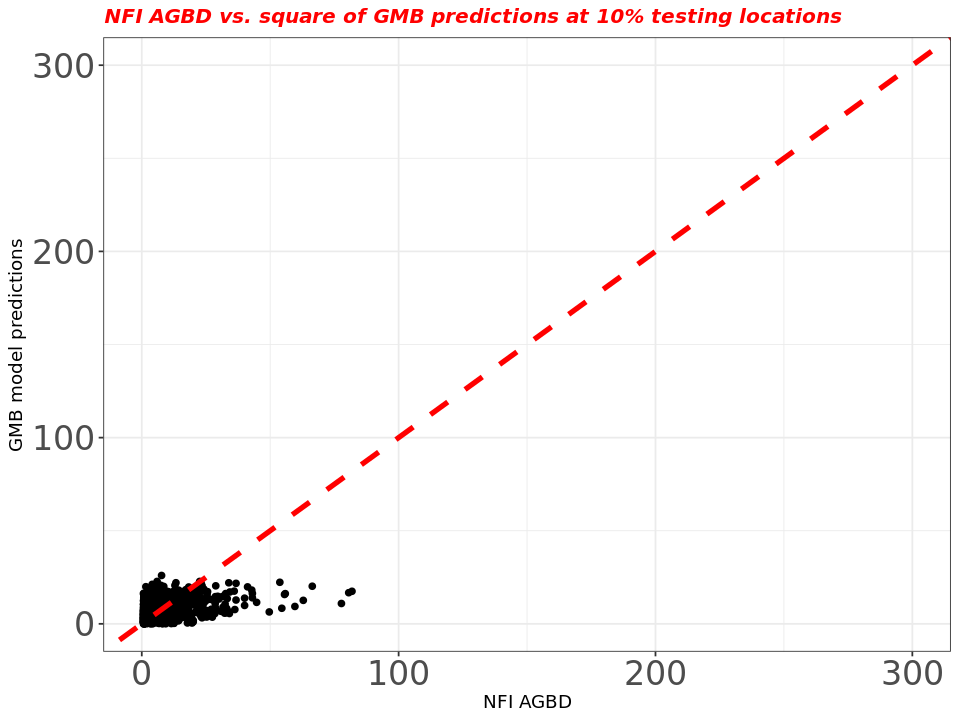

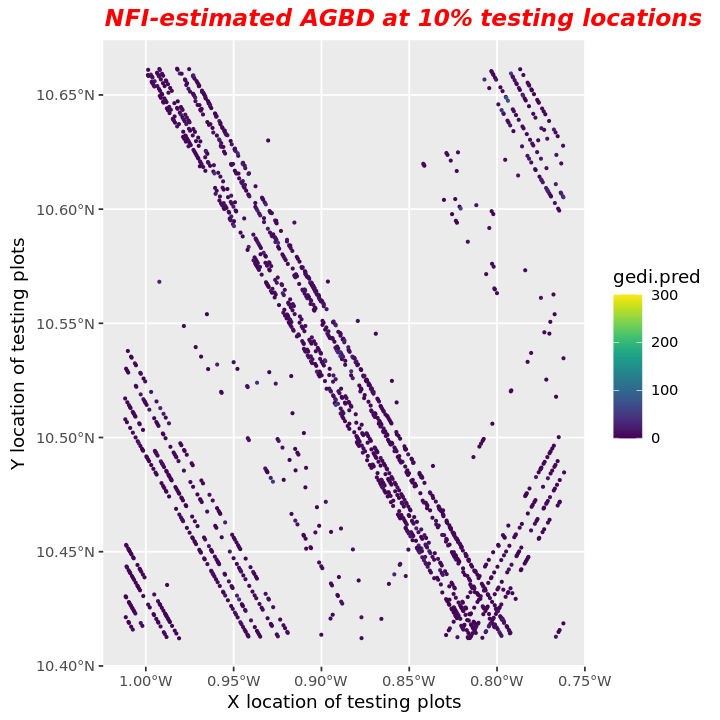

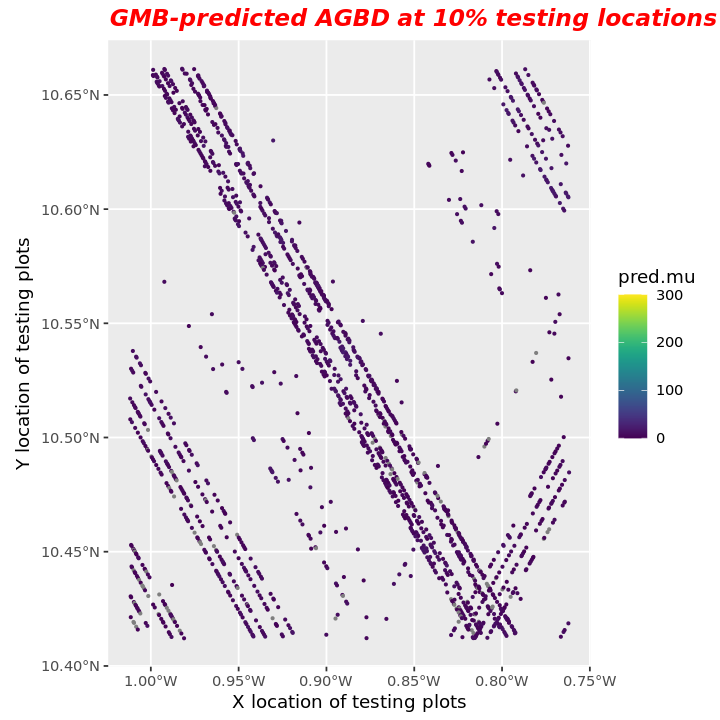

In [48]:
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/DATA_TEST.csv")

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)

samples = inla.posterior.sample(n = 250, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

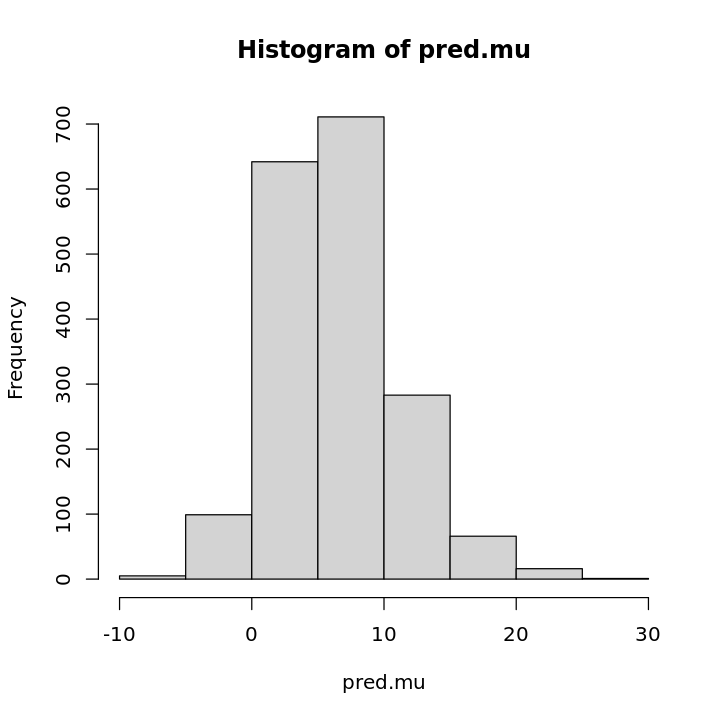

In [49]:
hist(pred.mu)